In [1]:
import pandas as pd

# load devnagari data
df = pd.read_csv("data/maibert_dataset.csv", encoding='utf-8')

df.head()

,text,labels,text_length,word_count,sentence_count
0,शीतलं निर्मलं तोयं कर्पूरेण सुवासितम्। आचम्यता...,Culture,163,24,4
1,देश भरि मे मंदिर के संख्या कतेक अछि ई सवाल आर्...,Entertainment,270,54,3
2,सो काल-खण्डमा कलम चलाउने कारीगरहरुले मातृशक्ति...,Culture,244,35,2
3,सिनेमाक निर्माण करबाक अछि।काठमांडू के मोएक्स ह...,Entertainment,812,142,6
4,मंगलवार क॑ राजधानी डुप्लीकेट ईस्ट वेस्ट कॉन्टा...,EduTech,2220,412,16


In [2]:
# Data exploration and preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nLabel distribution:")
print(df['labels'].value_counts())
print("\nBasic statistics:")
print(df.describe())


Using device: cpu
Dataset shape: (12383, 5)

Column names: ['text', 'labels', 'text_length', 'word_count', 'sentence_count']

Label distribution:
labels
Culture          2575
Literature       2212
Politics         2075
Sports           1774
Entertainment     844
Opinion           805
EduTech           619
Economy           549
Health            506
Interview         424
Name: count, dtype: int64

Basic statistics:
        text_length    word_count  sentence_count
count  12383.000000  12383.000000    12383.000000
mean     872.772591    158.615844        9.535654
std      876.017370    158.986193        9.475171
min        0.000000      1.000000        1.000000
25%      225.000000     38.000000        3.000000
50%      456.000000     86.000000        6.000000
75%     1265.000000    230.500000       13.000000
max     5277.000000    512.000000       86.000000


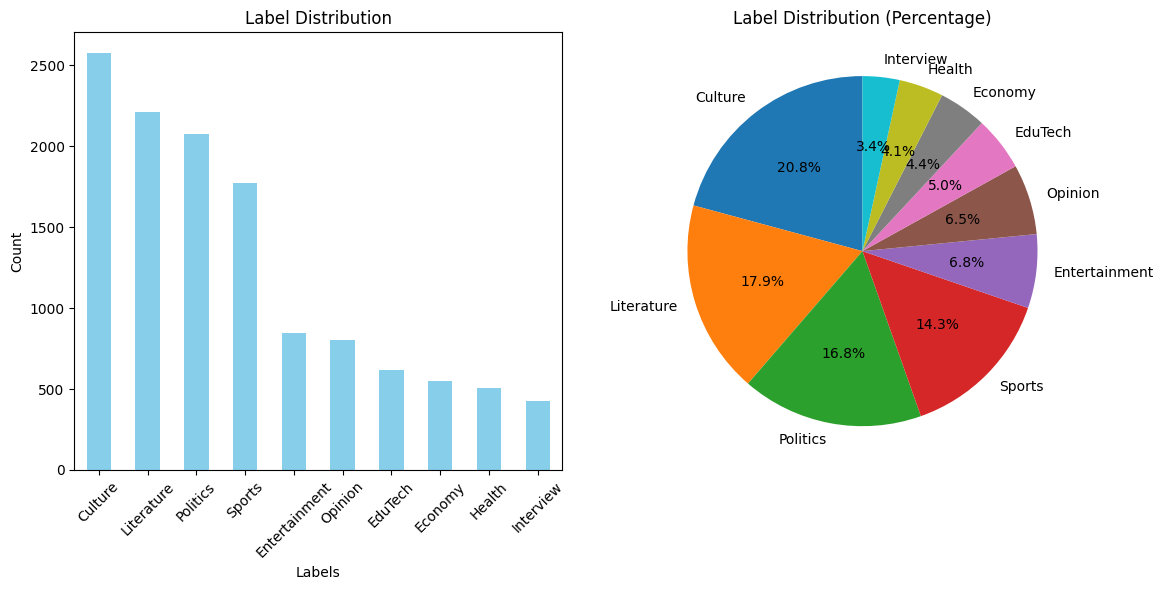

Missing values:
text              7
labels            0
text_length       0
word_count        0
sentence_count    0
dtype: int64


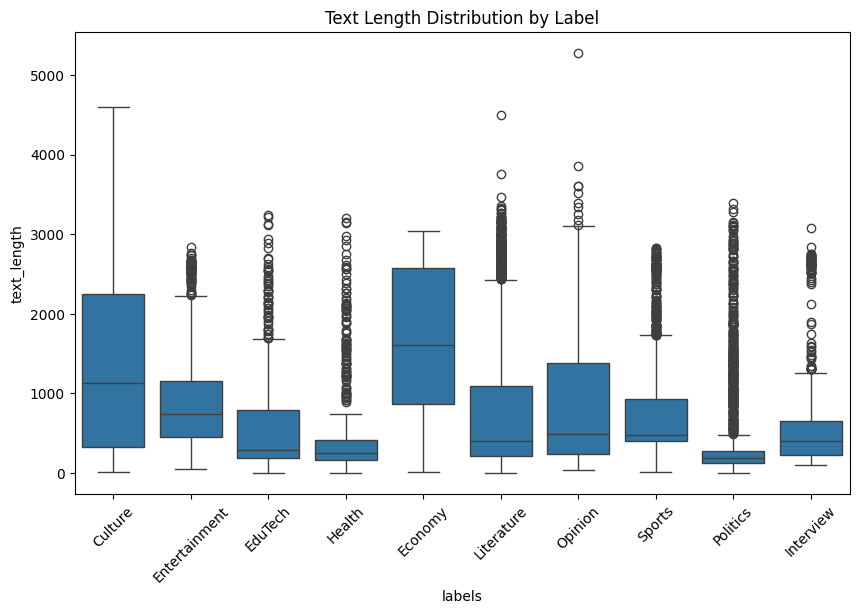

In [3]:
# Visualize label distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['labels'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check text length distribution by label
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='labels', y='text_length')
plt.title('Text Length Distribution by Label')
plt.xticks(rotation=45)
plt.show()


In [4]:
# Data preprocessing
# Clean and prepare the text data
df_clean = df.dropna(subset=['text', 'labels']).copy()
print(f"Dataset size after removing missing values: {df_clean.shape[0]}")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_clean['labels'])
print(f"Number of unique labels: {len(label_encoder.classes_)}")
print(f"Label classes: {label_encoder.classes_}")

# Text feature extraction using TF-IDF
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 features
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95,       # Ignore terms that appear in more than 95% of documents
    stop_words=None,   # No built-in stop words for Devanagari text
    ngram_range=(1, 2) # Use unigrams and bigrams
)

X = tfidf_vectorizer.fit_transform(df_clean['text']).toarray()
print(f"TF-IDF feature matrix shape: {X.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print(f"Training set shape: {X_train_tensor.shape}")
print(f"Test set shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Dataset size after removing missing values: 12376
Number of unique labels: 10
Label classes: ['Culture' 'Economy' 'EduTech' 'Entertainment' 'Health' 'Interview'
 'Literature' 'Opinion' 'Politics' 'Sports']
Extracting TF-IDF features...
TF-IDF feature matrix shape: (12376, 5000)
Training set shape: torch.Size([9900, 5000])
Test set shape: torch.Size([2476, 5000])
Training labels shape: torch.Size([9900])
Test labels shape: torch.Size([2476])


In [5]:
# Build PyTorch Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NeuralNetwork, self).__init__()
        
        # Input layer
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        # Hidden layers
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.2)
        
        # Output layer
        self.fc5 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Input layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Hidden layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout4(x)
        
        # Output layer (no softmax here, will use CrossEntropyLoss)
        x = self.fc5(x)
        return x

# Create the model
input_dim = X_train_tensor.shape[1]
num_classes = len(label_encoder.classes_)

model = NeuralNetwork(input_dim, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-7)

# Model summary
print("Model Architecture:")
print(model)

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
NeuralNetwork(
  (fc1): Linear(in_features=5000, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 2,735,434
Trainable parameters: 2,735,434


In [6]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Create validation split
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader_split = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Training parameters
num_epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader_split, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.2e}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("Training completed! Best model restored.")


Starting training...

Epoch 1/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1355.94it/s]


Train Loss: 1.2556, Train Acc: 58.78%
Val Loss: 0.8142, Val Acc: 72.53%
Learning Rate: 1.00e-03

Epoch 2/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1557.17it/s]


Train Loss: 0.6471, Train Acc: 78.84%
Val Loss: 0.7967, Val Acc: 72.78%
Learning Rate: 1.00e-03

Epoch 3/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1407.62it/s]


Train Loss: 0.3769, Train Acc: 88.17%
Val Loss: 0.9473, Val Acc: 71.52%
Learning Rate: 1.00e-03

Epoch 4/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1558.02it/s]


Train Loss: 0.2484, Train Acc: 92.26%
Val Loss: 0.9832, Val Acc: 71.52%
Learning Rate: 1.00e-03

Epoch 5/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1483.42it/s]


Train Loss: 0.1967, Train Acc: 94.15%
Val Loss: 1.0958, Val Acc: 70.40%
Learning Rate: 1.00e-03

Epoch 6/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1490.81it/s]


Train Loss: 0.1515, Train Acc: 95.28%
Val Loss: 1.2127, Val Acc: 71.31%
Learning Rate: 1.00e-03

Epoch 7/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1482.75it/s]


Train Loss: 0.1360, Train Acc: 95.76%
Val Loss: 1.2384, Val Acc: 71.67%
Learning Rate: 1.00e-03

Epoch 8/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1415.24it/s]


Train Loss: 0.1201, Train Acc: 96.48%
Val Loss: 1.2414, Val Acc: 71.92%
Learning Rate: 5.00e-04

Epoch 9/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1538.95it/s]


Train Loss: 0.0924, Train Acc: 97.10%
Val Loss: 1.2812, Val Acc: 72.22%
Learning Rate: 5.00e-04

Epoch 10/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1518.86it/s]


Train Loss: 0.0568, Train Acc: 98.11%
Val Loss: 1.3402, Val Acc: 72.12%
Learning Rate: 5.00e-04

Epoch 11/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1442.56it/s]


Train Loss: 0.0627, Train Acc: 97.97%
Val Loss: 1.3691, Val Acc: 72.53%
Learning Rate: 5.00e-04

Epoch 12/100
------------------------------


Validation: 100%|██████████| 62/62 [00:00<00:00, 1419.09it/s]

Train Loss: 0.0498, Train Acc: 98.26%
Val Loss: 1.3664, Val Acc: 73.03%
Learning Rate: 5.00e-04

Early stopping triggered after 12 epochs
Training completed! Best model restored.


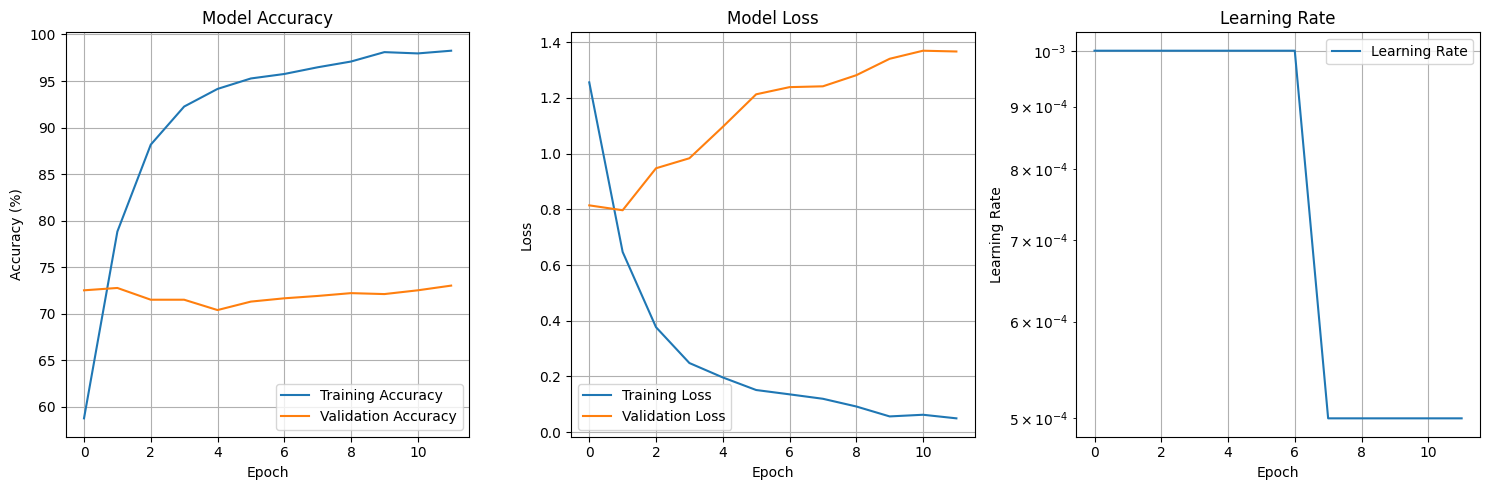

Best epoch: 2
Best validation accuracy: 73.03%
Best validation loss: 0.7967

Training Summary:
Total epochs: 12
Final training accuracy: 98.26%
Final validation accuracy: 73.03%
Final learning rate: 5.00e-04


In [7]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot learning rate
plt.subplot(1, 3, 3)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get the best epoch information
best_epoch = np.argmin(history['val_loss']) + 1
best_val_acc = max(history['val_acc'])
best_val_loss = min(history['val_loss'])

print(f"Best epoch: {best_epoch}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best validation loss: {best_val_loss:.4f}")

# Training summary
print(f"\nTraining Summary:")
print(f"Total epochs: {len(history['train_loss'])}")
print(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Final learning rate: {history['lr'][-1]:.2e}")


Evaluating on test set...


Evaluating: 100%|██████████| 78/78 [00:00<00:00, 1257.14it/s]

Test Accuracy: 72.62%
Test Loss: 0.7879

Classification Report:
               precision    recall  f1-score   support

      Culture       0.73      0.72      0.73       515
      Economy       0.68      0.83      0.75       110
      EduTech       0.44      0.32      0.37       124
Entertainment       0.62      0.70      0.66       169
       Health       0.59      0.48      0.53       101
    Interview       0.92      0.67      0.78        85
   Literature       0.66      0.78      0.72       441
      Opinion       0.74      0.68      0.71       161
     Politics       0.82      0.83      0.83       415
       Sports       0.85      0.77      0.81       355

     accuracy                           0.73      2476
    macro avg       0.71      0.68      0.69      2476
 weighted avg       0.73      0.73      0.72      2476



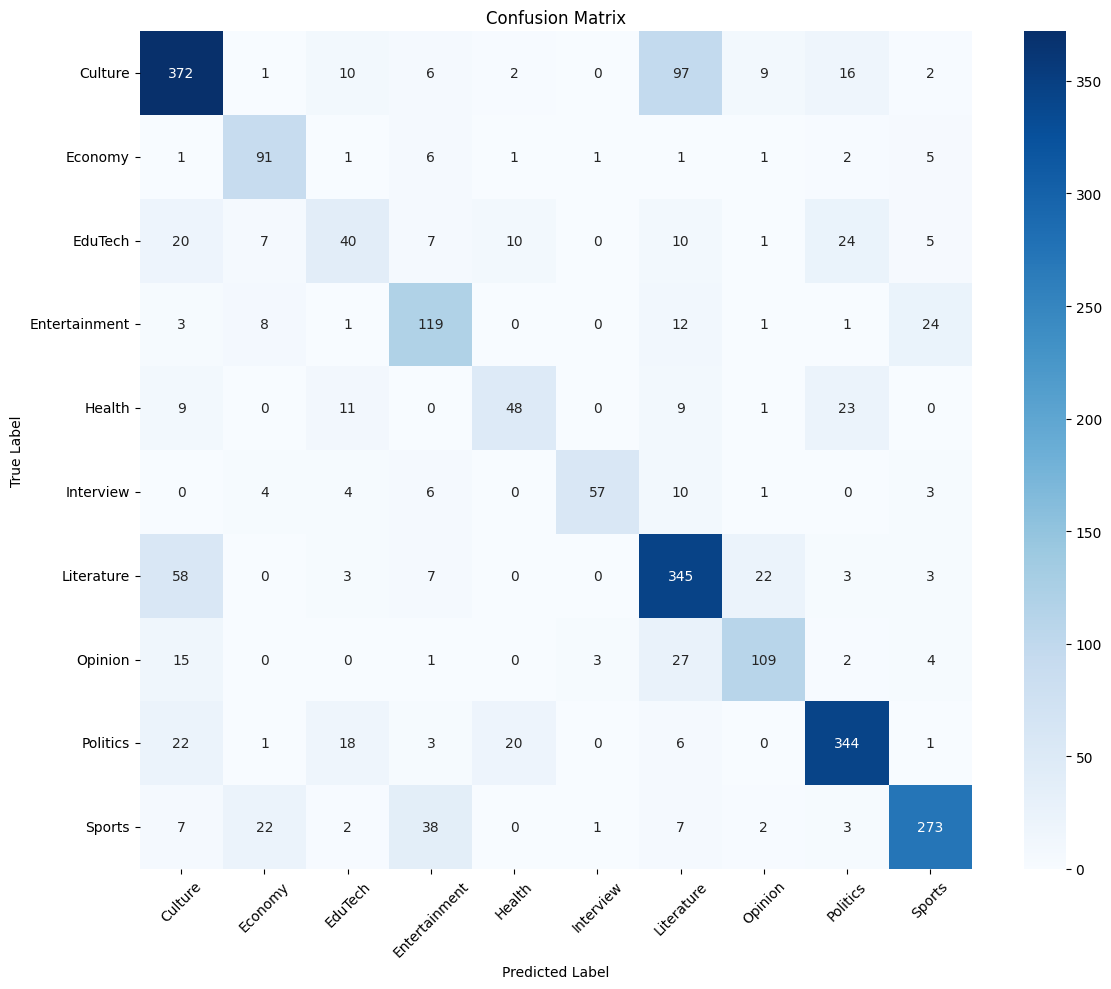


Per-class Accuracy:
Culture: 0.7223 (72.23%)
Economy: 0.8273 (82.73%)
EduTech: 0.3226 (32.26%)
Entertainment: 0.7041 (70.41%)
Health: 0.4752 (47.52%)
Interview: 0.6706 (67.06%)
Literature: 0.7823 (78.23%)
Opinion: 0.6770 (67.70%)
Politics: 0.8289 (82.89%)
Sports: 0.7690 (76.90%)

Overall Test Accuracy: 0.7262 (72.62%)

Macro-averaged Metrics:
Precision: 0.7062
Recall: 0.6779
F1-score: 0.6866

Detailed Class-wise Metrics:
Culture:
  Precision: 0.7337
  Recall: 0.7223
  F1-score: 0.7280
  Support: 515
Economy:
  Precision: 0.6791
  Recall: 0.8273
  F1-score: 0.7459
  Support: 110
EduTech:
  Precision: 0.4444
  Recall: 0.3226
  F1-score: 0.3738
  Support: 124
Entertainment:
  Precision: 0.6166
  Recall: 0.7041
  F1-score: 0.6575
  Support: 169
Health:
  Precision: 0.5926
  Recall: 0.4752
  F1-score: 0.5275
  Support: 101
Interview:
  Precision: 0.9194
  Recall: 0.6706
  F1-score: 0.7755
  Support: 85
Literature:
  Precision: 0.6584
  Recall: 0.7823
  F1-score: 0.7150
  Support: 441
Opini

In [8]:
# Evaluate on test set
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # Get probabilities and predictions
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    
    return avg_loss, accuracy, all_predictions, all_labels, all_probabilities

print("Evaluating on test set...")
test_loss, test_accuracy, y_pred, y_true, y_pred_proba = evaluate_model(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {per_class_accuracy[i]:.4f} ({per_class_accuracy[i]*100:.2f}%)")

# Overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Test Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# Additional metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
macro_precision = precision_recall_fscore_support(y_true, y_pred, average='macro')[0]
macro_recall = precision_recall_fscore_support(y_true, y_pred, average='macro')[1]
macro_f1 = precision_recall_fscore_support(y_true, y_pred, average='macro')[2]

print(f"\nMacro-averaged Metrics:")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall: {macro_recall:.4f}")
print(f"F1-score: {macro_f1:.4f}")

# Class-wise detailed metrics
print(f"\nDetailed Class-wise Metrics:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print(f"  Support: {support[i]}")


In [9]:
# Save the model and preprocessors
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'input_dim': input_dim,
        'num_classes': num_classes
    },
    'label_encoder': label_encoder,
    'device': str(device)
}, 'maibert_pytorch_model.pth')
print("Model saved as 'maibert_pytorch_model.pth'")

# Save the TF-IDF vectorizer and label encoder separately for easy loading
import joblib
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Preprocessors saved successfully!")

# Function to load the saved model
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model architecture
    model = NeuralNetwork(
        checkpoint['model_architecture']['input_dim'],
        checkpoint['model_architecture']['num_classes']
    ).to(device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, checkpoint['label_encoder']

# Function to predict new text
def predict_text_category(text, model, tfidf_vectorizer, label_encoder, device):
    """
    Predict the category of new text input using PyTorch model
    """
    model.eval()
    
    # Transform the text using the fitted TF-IDF vectorizer
    text_features = tfidf_vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_features).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(text_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class_idx].item()
    
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    # Get all class probabilities
    all_probabilities = {}
    for i, class_name in enumerate(label_encoder.classes_):
        all_probabilities[class_name] = probabilities[0][i].item()
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'all_probabilities': all_probabilities
    }

# Test the prediction function with a sample
if len(df_clean) > 0:
    sample_text = df_clean['text'].iloc[0]
    sample_true_label = df_clean['labels'].iloc[0]
    
    prediction = predict_text_category(sample_text, model, tfidf_vectorizer, label_encoder, device)
    
    print("\nSample Prediction:")
    print(f"Text: {sample_text[:100]}...")
    print(f"True Label: {sample_true_label}")
    print(f"Predicted Label: {prediction['predicted_class']}")
    print(f"Confidence: {prediction['confidence']:.4f}")
    
    print("\nAll Class Probabilities:")
    for class_name, prob in prediction['all_probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")

# Example of how to load and use the saved model
print(f"\n" + "="*60)
print("MODEL LOADING EXAMPLE:")
print("="*60)
print("# To load the model in the future:")
print("loaded_model, loaded_label_encoder = load_model('maibert_pytorch_model.pth', device)")
print("loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')")
print("prediction = predict_text_category(text, loaded_model, loaded_tfidf, loaded_label_encoder, device)")

print("\n" + "="*50)
print("PYTORCH NEURAL NETWORK TRAINING COMPLETED!")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Model saved as PyTorch checkpoint")
print("="*50)


Model saved as 'maibert_pytorch_model.pth'
Preprocessors saved successfully!

Sample Prediction:
Text: शीतलं निर्मलं तोयं कर्पूरेण सुवासितम्। आचम्यतां जलं ह्येतत् प्रसीद परमेश्वरि॥ ॐ महालक्ष्म्यै नम:, आच...
True Label: Culture
Predicted Label: Culture
Confidence: 0.8850

All Class Probabilities:
  Culture: 0.8850
  Economy: 0.0004
  EduTech: 0.0146
  Entertainment: 0.0006
  Health: 0.0055
  Interview: 0.0036
  Literature: 0.0736
  Opinion: 0.0067
  Politics: 0.0096
  Sports: 0.0004

MODEL LOADING EXAMPLE:
# To load the model in the future:
loaded_model, loaded_label_encoder = load_model('maibert_pytorch_model.pth', device)
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')
prediction = predict_text_category(text, loaded_model, loaded_tfidf, loaded_label_encoder, device)

PYTORCH NEURAL NETWORK TRAINING COMPLETED!
Final Test Accuracy: 72.62%
Best Validation Accuracy: 73.03%
Model saved as PyTorch checkpoint
